In [1]:
%matplotlib widget

In [2]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
seed=2024

### Define functions

In [3]:
def to_python_hdf5(dat:List, save_path: Path):
    """Save data in hdf5 format."""
    # save the data
    with h5py.File(save_path, "w") as f:
        for i_d in range(len(dat)):
            group = f.create_group(str(i_d))

            for key, value in zip(dat[i_d].keys(), dat[i_d].values()):
                group.create_dataset(key, np.array(value).shape, data=value)
    f.close()

In [4]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [5]:
def z_score(x):
    mu = np.mean(x,axis=0)
    sigma = np.std(x,axis=0)
    sigma0=sigma
    sigma0[sigma == 0] = 1 
    zs_x = (x-mu) / sigma0
    return zs_x

In [6]:
def get_fr_samples(sp,sample_id,start,end,samples):
    # parameters
    n_trials = 5
    win=50
    # Check fr
    ms_fr=np.nanmean(sp[:,start:end])*1000>5
    if not ms_fr:
        return None
    # Average spikes
    avg_sample = firing_rate.moving_average(sp, win=win, step = 1)
    fr_samples = []
    for s_id in samples:
        sample_fr = avg_sample[np.where(sample_id==s_id,True,False),start:end]
        # Check number of trials
        if sample_fr.shape[0]< n_trials:
            return None
        fr_samples.append(np.mean(sample_fr,axis=0))
    return fr_samples


In [7]:
def get_neuron_sample_fr(path,time_before,start,end,rng):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    # Select trials aligned to sample onset
    sp_sample_on,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    if np.sum(mask)<20:
        return {'fr':None}
    sample_id = neu_data.sample_id[mask]
    fr_samples = get_fr_samples(sp_sample_on,sample_id,start=start,end=end,samples=[0,11,15,55,51])
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

In [8]:
# def get_neuron_sample_fr(path,time_before,start,end,rng):
#     neu_data = NeuronData.from_python_hdf5(path)
#     fr_samples = get_fr_samples(neu_data,time_before=time_before,start=start,end=end)
#     if fr_samples is None:
#         return {'fr':None}
#     return {'fr':fr_samples}

In [9]:
def get_neuron_sample_test1_fr(path,time_before,start,end,end_test,n_test,rng):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on, mask_sample = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    sp_test1_on, mask_test1 = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="test_on_1",
        time_before = 200,
        error_type= 0,
    )
    if np.any(mask_sample != mask_test1):
        print(path)
        return 
    mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
    # mask_roll_nan = np.where(neu_data.test_stimuli[mask_test1]==neu_data.sample_id[mask_test1])
    # mask_match = mask_roll_nan[:,n_test-1]
    mask_neu = neu_data.sample_id[mask_test1]==0
    mask_match_neu = np.logical_or(mask_match,mask_neu)
    if np.sum(mask_match_neu)<20:
        return {'fr':None}
 
    sp=np.concatenate((sp_sample_on[mask_match_neu,:time_before+450+200],sp_test1_on[mask_match_neu,:end_test+400]),axis=1)

    sample_id = neu_data.sample_id[mask_test1][mask_match_neu]
    fr_samples = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51])
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

### Read data

In [10]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [11]:
area='lip'
neu_path = basepath+'/session_struct/'+area+'/neurons/*neu.h5'
path_list = glob.glob(neu_path)

In [12]:
# Load data
n_test=4
time_before=500
start=-200
end_test = 200+n_test*450
end=450+200+end_test+200#850

idx_start = time_before + start 
idx_end = time_before+end
rng = np.random.default_rng(seed=seed)
data = Parallel(n_jobs = -1)(delayed(get_neuron_sample_test1_fr)(path,time_before,start,end,end_test,n_test,rng) for path in tqdm(path_list))

100%|██████████| 530/530 [01:49<00:00,  4.83it/s]


In [13]:
neurons_fr = []
for asc in data:
    fr = asc["fr"]
    if fr is not None:
        neurons_fr.append(asc)
to_python_hdf5(dat=neurons_fr, save_path='C:/Users/camil/Downloads/pca/'+area+'_win50_test'+str(n_test)+'_pca.h5')

In [14]:
neurons_fr_read=from_python_hdf5(load_path='C:/Users/camil/Downloads/pca/'+area+'_win50_test'+str(n_test)+'_pca.h5')
neurons_fr = []
for asc in neurons_fr_read:
    fr = asc["fr"]
    if fr is not None:
        fr_concat = np.concatenate(fr,axis=0)
        neurons_fr.append(fr_concat)

In [15]:
neurons_fr = np.array(neurons_fr)#.reshape(-1,1050)
neurons_fr.shape

(74, 15250)

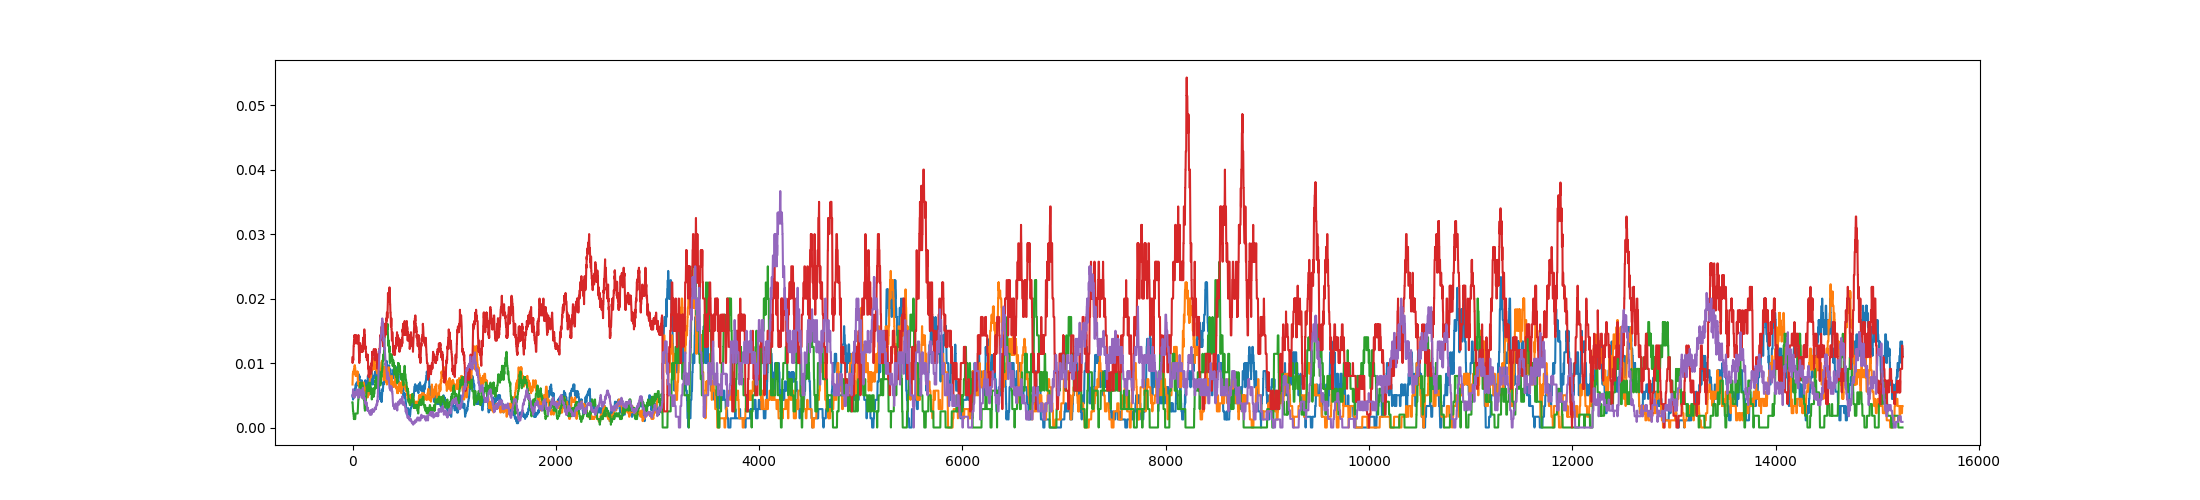

In [16]:
plt.subplots(figsize=(22,5))
_=plt.plot(neurons_fr[0:5].T)